In [3]:
import pandas as pd
import numpy as np
import pyreadr
import matplotlib.pyplot as plt
import seaborn as sns
import zstandard as zstd
import os

In [4]:
os.chdir("/home/lucytian/data/1_Single_Cell_PRS/2_cV2F")

In [5]:
df_ldlc = pd.read_csv('LDL-C_SNPs.tsv', sep='\t')
df_egfr = pd.read_csv('eGFR_SNPs.tsv', sep='\t')
df_fev = pd.read_csv('FEV1_FVC ratio_SNPs.tsv', sep='\t')
df_lymph = pd.read_csv('Lymphocyte Count_SNPs.tsv', sep='\t')

In [6]:
pheno_name_dict = {'INI30120' : 'Lymphocyte Count', 'INI50030700': 'eGFR', 'INI1003063': 'FEV1/FVC ratio', 'INI20030780': 'LDL-C'}
pheno_tissue = {'INI30120' : 'BLOOD', 'INI50030700': 'KIDNEY', 'INI1003063': 'LUNG', 'INI20030780': 'LIVER'}
pheno_df = {'INI30120' : df_lymph, 'INI50030700': df_egfr, 'INI1003063': df_fev, 'INI20030780': df_ldlc}

In [8]:
base_d = 'baselines/406k_geno_v2_UKB_18PCs/fit_w_val/'
data_d = 'mvp_afr_0.9_0.01/20231221/406k_geno_v2_UKB_18PCs/fit_w_val/'

In [9]:
annot = pd.read_csv('ukb_genoHM3_mvp_afr_tissue_cV2F.annot.pvar.gz', sep='\t', compression='gzip', low_memory=False)

In [11]:
pheno_cutoff = {'INI30120' : [(-0.01424188983771295, 0.01437715032263884), (0.003730393409981385)], 'INI50030700': [(-0.0026019049088767767, 0.002584641427304781), (0.00111723358240901)], 'INI1003063': [(-0.0011604225814833646, 0.0011592844606901993), (0.0005859056053312401)], 'INI20030780': [(-0.007907717569580417, 0.007875850803617345), (0.00614153189596929)]}
pheno_name_dict = {'INI30120' : 'Lymphocyte Count', 'INI50030700': 'eGFR', 'INI1003063': 'FEV1/FVC ratio', 'INI20030780': 'LDL-C'}

In [30]:
from adjustText import adjust_text
palette = {
    'Group A': '#DC267F',
    'Group C': '#785EF0',
    'Group B': '#FE6100',
    'Group D' : 'grey'
}

In [31]:
marker_dict = {
    'Group C': 'D',  
    'Group B': 'D',  
    'Group A': 'D',  
    'Group D': 'X',
}

In [32]:
cutoffs = {'BLOOD': 0.7324814022, 'LIVER': 0.6460890472, 'LUNG': 0.6198484063, 'KIDNEY': 0.619365716}

In [33]:
tissue_trait_dict = {'INI30120' : 'BLOOD', 'INI50030700': 'KIDNEY', 'INI1003063': 'LUNG', 'INI20030780': 'LIVER'}

In [34]:
group_new_dict = {'cV2F_prioritized': 'Group C', 'beta_deviation': 'Group B', 'overlap': 'Group A', 'NOT_SIG': 'Group D'}

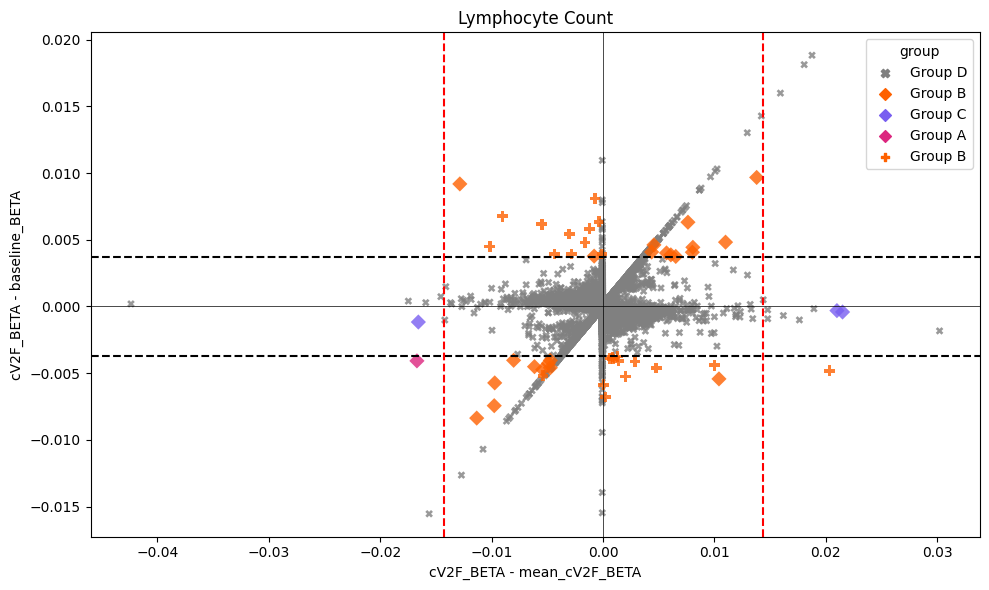

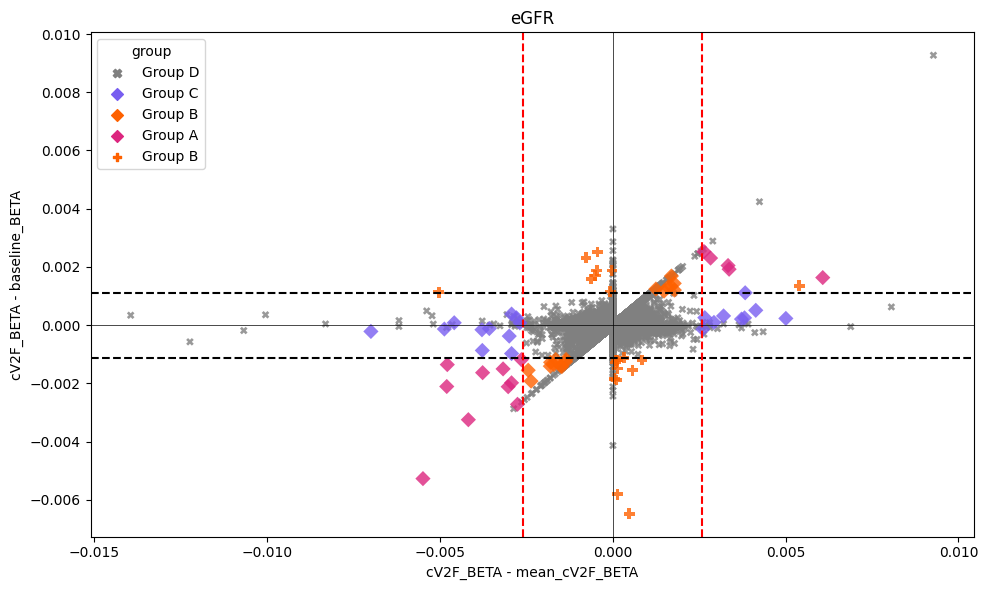

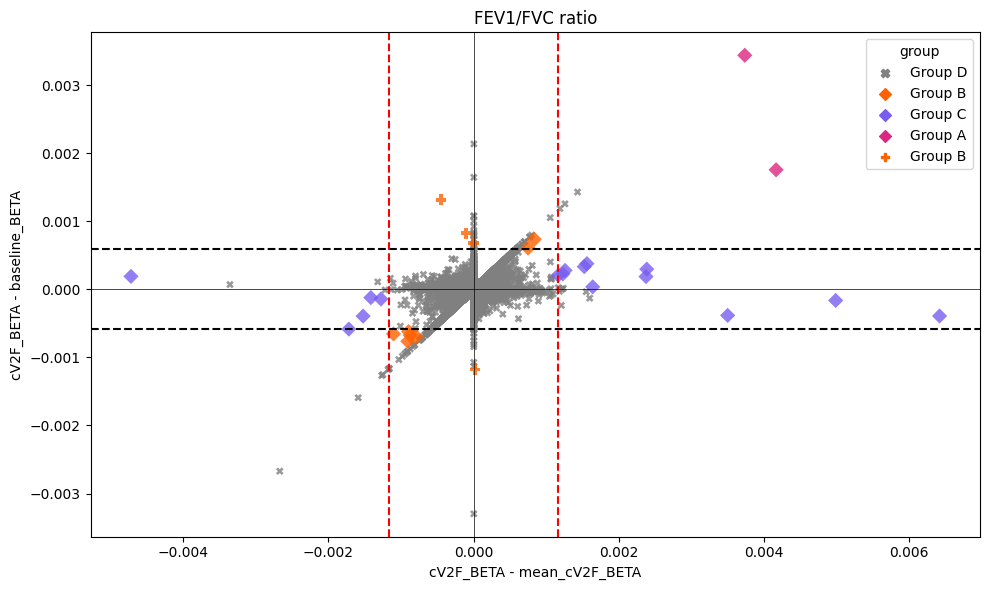

In [35]:
for tr in ['INI30120', 'INI50030700', 'INI1003063']:
    df_beta = pd.read_csv(data_d + pheno_tissue[tr] + '/' + tr + '/snpnet.BETAs.tsv.gz', sep='\t', compression='gzip')
    df_beta = df_beta.iloc[23:, :]
    df_beta_base = pd.read_csv(base_d + tr + '/snpnet.BETAs.tsv.gz', sep='\t', compression='gzip')
    df_beta_base = df_beta_base.iloc[23:, :]
    merged = df_beta_base.merge(df_beta, on='#ID', how='outer')
    merged = merged.rename(columns={'A1_x': 'A_baseline', 'BETA_x': 'BETA_baseline', 'A1_y': 'A_cV2F', 'BETA_y': 'BETA_cV2F'})
    merged['A_cV2F'] = merged['A_baseline']
    merged['BETA_baseline'] = merged['BETA_baseline'].fillna(0)
    merged['BETA_cV2F'] = merged['BETA_cV2F'].fillna(0)
    merged = merged.merge(annot[['#CHROM', 'POS', 'rsID', 'ID', 'Csq_group', 'cV2F_' + pheno_tissue[tr]]], left_on='#ID', right_on='ID')
    merged['cV2F_' + pheno_tissue[tr]] = merged['cV2F_' + pheno_tissue[tr]].fillna(0)
    merged['cV2F_BETA - baseline_BETA'] = merged['BETA_cV2F'] - merged['BETA_baseline']
    merged['cV2F_BETA - mean_cV2F_BETA'] = merged['BETA_cV2F'] - np.mean(merged['BETA_cV2F'])
    merged = merged.merge(pheno_df[tr][['rsID', 'group']], on='rsID', how='left')
    #merged['group'] = merged['group'].fillna('Group D')
    merged['group'] = merged['group'].apply(lambda x:group_new_dict[x] )



    y_cutoff = pheno_cutoff[tr][1]
    x_cutoff1 = pheno_cutoff[tr][0][0]
    x_cutoff2 = pheno_cutoff[tr][0][1]
    x_offset = 0
    y_offset = 0.001


    plt.figure(figsize=(10, 6)) 
    merged_1 = merged[merged['group']!= 'Group D']
    markers = [marker_dict[c] for c in merged_1['group'].unique()]
    sns.scatterplot(merged[merged['group']== 'Group D'], x='cV2F_BETA - mean_cV2F_BETA', y='cV2F_BETA - baseline_BETA', hue='group', style='group', palette=palette, s=30, markers='X', alpha=0.8, linewidth=0)
    sns.scatterplot(merged_1[merged_1[f'cV2F_{tissue_trait_dict[tr]}'] > cutoffs[tissue_trait_dict[tr]]], x='cV2F_BETA - mean_cV2F_BETA', y='cV2F_BETA - baseline_BETA', hue='group', style='group', palette=palette, s=60, markers=markers, alpha=0.8, linewidth=0)
    sns.scatterplot(merged_1[merged_1[f'cV2F_{tissue_trait_dict[tr]}'] < cutoffs[tissue_trait_dict[tr]]], x='cV2F_BETA - mean_cV2F_BETA', y='cV2F_BETA - baseline_BETA', palette=palette, hue='group', style='group', s=60, markers='P', alpha=0.8, linewidth=0)    

    
    plt.axhline(y=y_cutoff, color='black', linestyle='--')
    plt.axhline(y=-y_cutoff, color='black', linestyle='--') 
    plt.axvline(x=x_cutoff1, color='red', linestyle='--') 
    plt.axvline(x=x_cutoff2, color='red', linestyle='--')
    plt.axvline(x=0, color='black', linestyle='-', linewidth = 0.5)
    plt.axhline(y=0, color='black', linestyle='-', linewidth = 0.5)

    x_min = min(merged['cV2F_BETA - mean_cV2F_BETA'].min(), merged['cV2F_BETA - baseline_BETA'].min())
    x_max = max(merged['cV2F_BETA - mean_cV2F_BETA'].max(), merged['cV2F_BETA - baseline_BETA'].max())

    # Generate x values
    x = np.linspace(x_min, x_max, 100)
    y = x  # y = x

    plt.title(pheno_name_dict[tr]);
    plt.tight_layout()

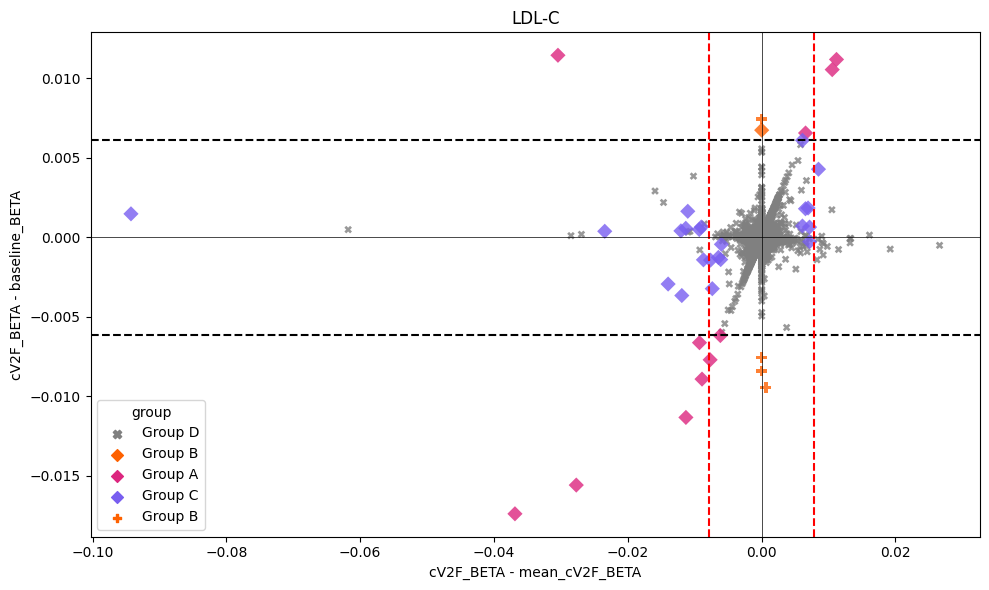

In [36]:
tr = 'INI20030780'
df_beta = pd.read_csv(data_d + pheno_tissue[tr] + '/' + tr + '/exclude_APOE/snpnet.BETAs.tsv.gz', sep='\t', compression='gzip')
df_beta = df_beta.iloc[23:, :]
df_beta_base = pd.read_csv(base_d + tr + '/exclude_APOE/snpnet.BETAs.tsv.gz', sep='\t', compression='gzip')
df_beta_base = df_beta_base.iloc[23:, :]
merged = df_beta_base.merge(df_beta, on='#ID', how='outer')
merged = merged.rename(columns={'A1_x': 'A_baseline', 'BETA_x': 'BETA_baseline', 'A1_y': 'A_cV2F', 'BETA_y': 'BETA_cV2F'})
merged['A_cV2F'] = merged['A_baseline']
merged['BETA_baseline'] = merged['BETA_baseline'].fillna(0)
merged['BETA_cV2F'] = merged['BETA_cV2F'].fillna(0)
merged = merged.merge(annot[['#CHROM', 'POS', 'rsID', 'ID', 'Csq_group', 'cV2F_' + pheno_tissue[tr]]], left_on='#ID', right_on='ID')
merged['cV2F_' + pheno_tissue[tr]] = merged['cV2F_' + pheno_tissue[tr]].fillna(0)
merged['cV2F_BETA - baseline_BETA'] = merged['BETA_cV2F'] - merged['BETA_baseline']
merged['cV2F_BETA - mean_cV2F_BETA'] = merged['BETA_cV2F'] - np.mean(merged['BETA_cV2F'])
merged = merged.merge(pheno_df[tr][['rsID', 'group']], on='rsID', how='left')
#merged['group'] = merged['group'].fillna('Group D')
merged['group'] = merged['group'].apply(lambda x:group_new_dict[x] )



y_cutoff = pheno_cutoff[tr][1]
x_cutoff1 = pheno_cutoff[tr][0][0]
x_cutoff2 = pheno_cutoff[tr][0][1]
x_offset = 0
y_offset = 0.001


plt.figure(figsize=(10, 6)) 
merged_1 = merged[merged['group']!= 'Group D']
markers = [marker_dict[c] for c in merged_1['group'].unique()]
sns.scatterplot(merged[merged['group']== 'Group D'], x='cV2F_BETA - mean_cV2F_BETA', y='cV2F_BETA - baseline_BETA', hue='group', style='group', palette=palette, s=30, markers='X', alpha=0.8, linewidth=0)
sns.scatterplot(merged_1[merged_1[f'cV2F_{tissue_trait_dict[tr]}'] > cutoffs[tissue_trait_dict[tr]]], x='cV2F_BETA - mean_cV2F_BETA', y='cV2F_BETA - baseline_BETA', hue='group', style='group', palette=palette, s=60, markers=markers, alpha=0.8, linewidth=0)
sns.scatterplot(merged_1[merged_1[f'cV2F_{tissue_trait_dict[tr]}'] < cutoffs[tissue_trait_dict[tr]]], x='cV2F_BETA - mean_cV2F_BETA', y='cV2F_BETA - baseline_BETA', palette=palette, hue='group', style='group', s=60, markers='P', alpha=0.8, linewidth=0)    

    
plt.axhline(y=y_cutoff, color='black', linestyle='--')
plt.axhline(y=-y_cutoff, color='black', linestyle='--') 
plt.axvline(x=x_cutoff1, color='red', linestyle='--') 
plt.axvline(x=x_cutoff2, color='red', linestyle='--')
plt.axvline(x=0, color='black', linestyle='-', linewidth = 0.5)
plt.axhline(y=0, color='black', linestyle='-', linewidth = 0.5)

x_min = min(merged['cV2F_BETA - mean_cV2F_BETA'].min(), merged['cV2F_BETA - baseline_BETA'].min())
x_max = max(merged['cV2F_BETA - mean_cV2F_BETA'].max(), merged['cV2F_BETA - baseline_BETA'].max())

# Generate x values
x = np.linspace(x_min, x_max, 100)
y = x  # y = x

plt.title(pheno_name_dict[tr]);
plt.tight_layout()